In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the Excel file into a Pandas dataframe
df = pd.read_excel('data/Roads_InfoAboutEachLRP.xlsx')
bridges1 = pd.read_excel('data/Bridges.xlsx')
bridge2 = pd.read_excel('data/BMMS_overview.xlsx')

In [3]:
df.isnull().sum()

road        81
chainage    85
lrp         84
lat         85
lon         85
type        85
name        89
dtype: int64

<Axes: >

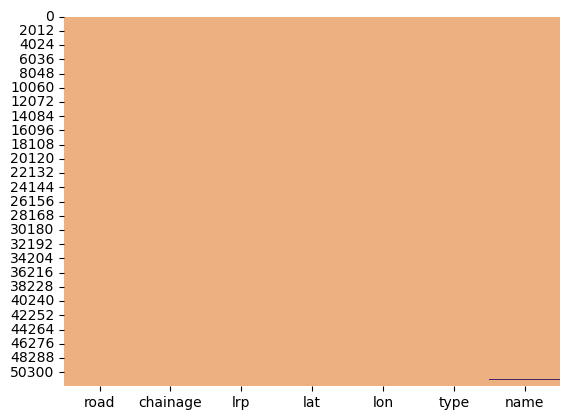

In [4]:
sns.heatmap(df.isnull(),cbar=False,cmap='flare')

In [5]:
junkdata=df[df['chainage'].isna()]
junkdata

,road,chainage,lrp,lat,lon,type,name
1934,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3738,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11769,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11772,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11774,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
51454,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51460,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51463,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: xlabel='lat', ylabel='lon'>

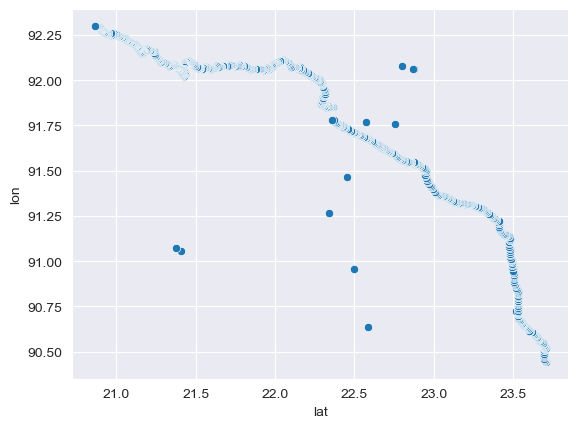

In [6]:
sns.set_style('darkgrid')
sns.scatterplot(x='lat', y='lon', data=df.loc[df.road=='N1'])

In [7]:
N1 = df.loc[df.road=='N1']
N1.shape
highList=pd.unique(df.road)

In [8]:
roadMap=pd.DataFrame()
for ID in highList:
    road = df.loc[df.road==ID]
    road.reset_index() 
    for count in range(0,3):
        for i in road.index:
            #loop1, loop2, loop3 = False, False, False 
            # check if i is inside first or last five iterations and compute moving averages acordingly 
            while i in range(5, len(road)-5):
                x_min, x_max = road.loc[i-5:i+5,'lon'].median() * .999 , road.loc[i-5:i+5,'lon'].median() * 1.001 # how big do we want to make search depth?
                y_min, y_max = road.loc[i-5:i+5,'lat'].median() * .999,  road.loc[i-5:i+5,'lat'].median() * 1.001 

                if not x_min <  road.loc[i,'lon'] < x_max: # check for outliers and overwrite 
                    road.loc[i,'lon'] = (road.loc[i-1,'lon'] + road.loc[i+1,'lon']) / 2 # position point right in between last and next point 

                if not y_min < road.loc[i,'lat'] < y_max:
                    road.loc[i,'lat'] = (road.loc[i-1,'lat'] + road.loc[i+1,'lat']) / 2 # position point right in between last and next point 
                #else: 
                    #loop2 = True 

                i+=1
                break 
    roadMap=pd.concat([roadMap,road])

In [9]:
roadMap.shape

(52214, 7)

In [10]:
roadMap=roadMap.reset_index()

<Axes: xlabel='lat', ylabel='lon'>

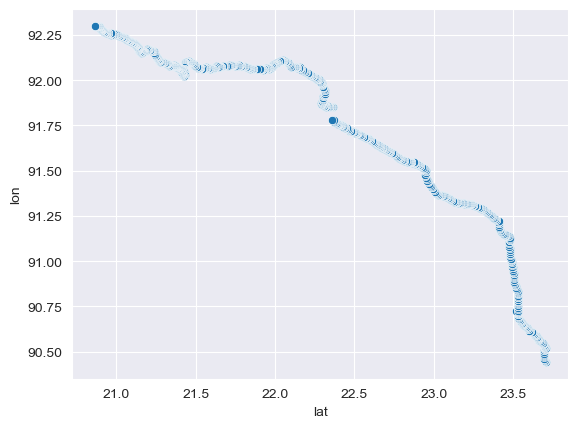

In [11]:
sns.scatterplot(x='lat',y='lon',data=roadMap.loc[roadMap.road=='N1'])

Now let'S calculatae the distance between two points on the surface of a sphere (we need to account for earth's curvature) using the Haversine formula.

In [12]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # radius of the Earth in kilometers
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c
    return distance

In [13]:
N1.shape

(1348, 7)

In [14]:
roadMap = roadMap.reset_index(drop=True)
roadMap['distance'] = 0.0  # initialize

current_road = None
cum_dist = 0.0

for i in range(len(roadMap)):
    road = roadMap.iloc[i]['road']
    if i == 0 or road != current_road:
        # starting a new road segment
        cum_dist = 0.0
    else:
        # previous point (i-1) to current point (i)
        lat1 = roadMap.iloc[i-1]['lat']
        lon1 = roadMap.iloc[i-1]['lon']
        lat2 = roadMap.iloc[i]['lat']
        lon2 = roadMap.iloc[i]['lon']
        cum_dist += haversine(lat1, lon1, lat2, lon2)

    roadMap.at[i, 'distance'] = cum_dist
    current_road = road

In [15]:
roadMap.shape

(52214, 9)

In [17]:
roadMap.head()

,index,road,chainage,lrp,lat,lon,type,name,distance
0,0,N1,0.000,LRPS,23.706028,90.443333,Others,Start of Road after Jatrabari Flyover infront...,0.000000
1,1,N1,0.814,LRPSa,23.702917,90.450417,Culvert,Box Culvert,0.799892
2,2,N1,0.822,LRPSb,23.702778,90.450472,CrossRoad,Intersection with Z1101,0.816338
3,3,N1,1.000,LRP001,23.702139,90.451972,KmPost,Km post missing,0.984776
4,4,N1,2.000,LRP002,23.697889,90.460583,KmPost,Km post missing,1.980800


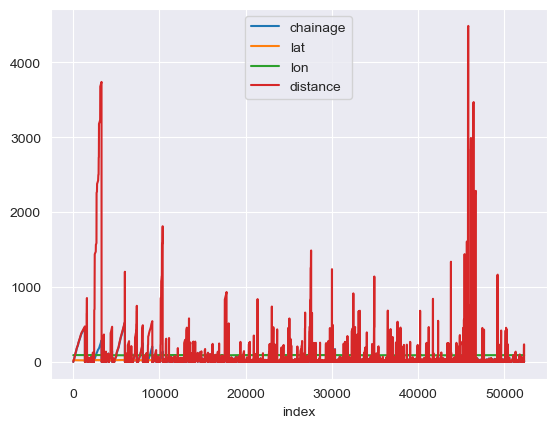

In [20]:
roadMap.plot('index')
plt.show()

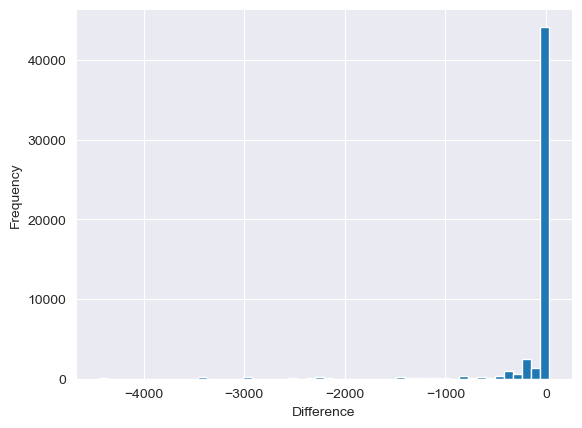

In [21]:
comparison = roadMap['chainage'] - roadMap['distance']

plt.hist(comparison, bins=50)
plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.show()

In [22]:
frameRoad = pd.DataFrame()
for ID in highList:
    road = roadMap.loc[roadMap.road == ID]
    road = road.reset_index(drop=True) # reset the index
    for i in range(len(road)): # iterate over the rows using integer indexes
        frameRoad.loc[i, ID] = road.loc[i,'chainage']-road.loc[i, 'distance']

<Axes: >

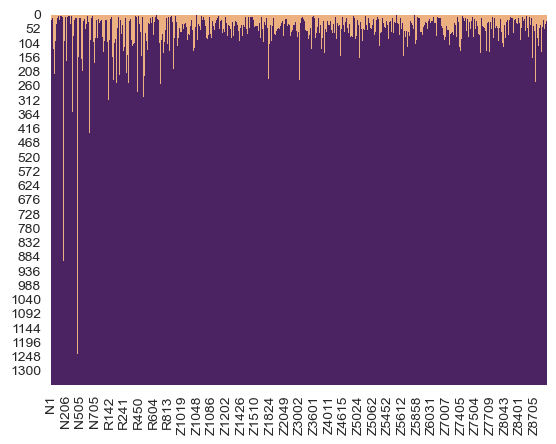

In [23]:
sns.heatmap(frameRoad.isnull(),cbar=False,cmap='flare')

In [24]:
frameRoad.isnull().sum()

N1          0
N101     1331
N102     1126
N103     1336
N104     1223
         ... 
Z8910    1262
Z8913    1297
Z8915    1316
Z8916    1325
Z8943    1328
Length: 880, dtype: int64

In [25]:
frameRoad.dropna(axis=1)

,N1
0,0.000000
1,0.014108
2,0.005662
3,0.015224
4,0.019200
...,...
1343,-11.708643
1344,-11.706819
1345,-11.705385
1346,-11.716158


In [26]:
rameRoad=frameRoad.fillna(0)
highList = highList[~pd.isnull(highList)]
variance=[]
for ID in highList:
    var=frameRoad[ID].var()
    variance.append(var)

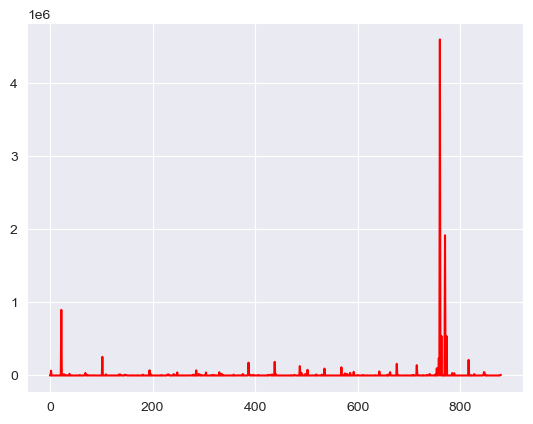

In [27]:
plt.plot(variance, color="red")
plt.show()

In [28]:
roadMap=roadMap.drop(['distance'],axis=1)
roadMap.to_excel('CleanedData.xlsx')

In [29]:
roadMap.head()

,index,road,chainage,lrp,lat,lon,type,name
0,0,N1,0.000,LRPS,23.706028,90.443333,Others,Start of Road after Jatrabari Flyover infront...
1,1,N1,0.814,LRPSa,23.702917,90.450417,Culvert,Box Culvert
2,2,N1,0.822,LRPSb,23.702778,90.450472,CrossRoad,Intersection with Z1101
3,3,N1,1.000,LRP001,23.702139,90.451972,KmPost,Km post missing
4,4,N1,2.000,LRP002,23.697889,90.460583,KmPost,Km post missing


In [30]:
bridgeFrame=bridges1.loc[bridges1.RoadNo=='N1']
bridgeFrame.head()
#degrees+min/60+sec/3600

,Number,StructureName,StructureType,Condition of Bridge,TotalWidth,TotalLength,ConstructionYear,NumberOfSpan,Zone,Circle,...,LocationLRPOffset,LocationChainage,LatitudeDegree,LatitudeMinute,LatitudeSecond,LongitudeDegree,LongitudeMinute,LongitudeSecond,Unnamed: 24,BCS1TotalScore
0,1.0,Kanch pur Bridge.,PC Girder Bridge,A,14.55,394.23,1986.0,8.0,Dhaka,Dhaka,...,3976.0,8.976,23.0,42.0,7.5,90.0,30.0,57.3,NaN,0.0
1,2.0,Madanpur Bridge.(L),PC Girder Bridge,A,9.20,27.50,2003.0,1.0,Dhaka,Dhaka,...,305.0,12.660,23.0,41.0,28.4,90.0,32.0,41.6,NaN,0.0
2,3.0,Madanpur Bridge(R),PC Girder Bridge,A,9.12,27.50,2007.0,1.0,Dhaka,Dhaka,...,333.0,12.688,23.0,41.0,28.0,90.0,32.0,41.6,NaN,0.0
3,4.0,Langalbandh Bridge.,RCC Girder Bridge,B,17.80,159.52,1998.0,5.0,Dhaka,Dhaka,...,1672.0,17.134,23.0,39.0,33.9,90.0,34.0,10.9,NaN,31.0
4,5.0,Darikandi Bridge (L),PC Girder Bridge,A,9.15,20.50,2002.0,1.0,Dhaka,Dhaka,...,2260.0,17.222,23.0,39.0,21.8,90.0,34.0,27.7,NaN,0.0


In [31]:
for i in bridgeFrame.index:
	value=bridgeFrame.loc[i,'LatitudeDegree']+(bridgeFrame.loc[i,'LatitudeMinute']/60)+(bridgeFrame.loc[i,'LatitudeSecond']/3600)
	bridgeFrame.loc[i,'Lat']=value
	value=bridgeFrame.loc[i,'LongitudeDegree']+(bridgeFrame.loc[i,'LongitudeMinute']/60)+(bridgeFrame.loc[i,'LongitudeSecond']/3600)
	bridgeFrame.loc[i,'Lon']=value

In [32]:
bridgeFrame.head()

,Number,StructureName,StructureType,Condition of Bridge,TotalWidth,TotalLength,ConstructionYear,NumberOfSpan,Zone,Circle,...,LatitudeDegree,LatitudeMinute,LatitudeSecond,LongitudeDegree,LongitudeMinute,LongitudeSecond,Unnamed: 24,BCS1TotalScore,Lat,Lon
0,1.0,Kanch pur Bridge.,PC Girder Bridge,A,14.55,394.23,1986.0,8.0,Dhaka,Dhaka,...,23.0,42.0,7.5,90.0,30.0,57.3,NaN,0.0,23.702083,90.515917
1,2.0,Madanpur Bridge.(L),PC Girder Bridge,A,9.20,27.50,2003.0,1.0,Dhaka,Dhaka,...,23.0,41.0,28.4,90.0,32.0,41.6,NaN,0.0,23.691222,90.544889
2,3.0,Madanpur Bridge(R),PC Girder Bridge,A,9.12,27.50,2007.0,1.0,Dhaka,Dhaka,...,23.0,41.0,28.0,90.0,32.0,41.6,NaN,0.0,23.691111,90.544889
3,4.0,Langalbandh Bridge.,RCC Girder Bridge,B,17.80,159.52,1998.0,5.0,Dhaka,Dhaka,...,23.0,39.0,33.9,90.0,34.0,10.9,NaN,31.0,23.659417,90.569694
4,5.0,Darikandi Bridge (L),PC Girder Bridge,A,9.15,20.50,2002.0,1.0,Dhaka,Dhaka,...,23.0,39.0,21.8,90.0,34.0,27.7,NaN,0.0,23.656056,90.574361


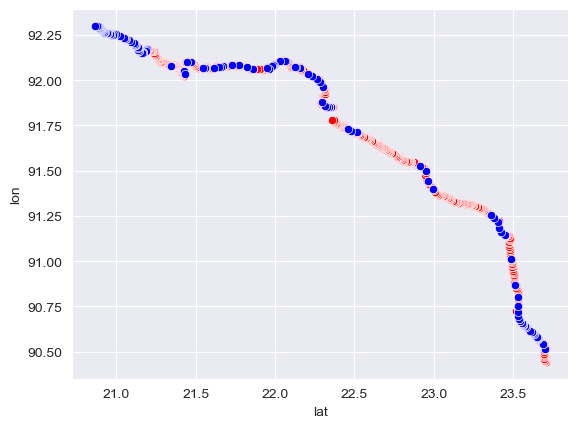

In [33]:
ax= plt.subplots()
ax=sns.scatterplot(x='lat',y='lon',data=roadMap.loc[roadMap.road=='N1'],color='r')
ax=sns.scatterplot(x='Lat', y='Lon', data=bridgeFrame.loc[bridgeFrame.RoadNo=='N1'],color='b')

plt.show()

In [34]:
lrpRoad=pd.unique(roadMap.lrp)
lrpBridge=pd.unique(bridge2.LRPName)
count=0
for i in lrpBridge:
	if i in lrpRoad:
		count+=1
print('count of coinciding bridges and Road LRPs is '+str(count))
print(str(len(lrpBridge)))
print(str(len(lrpRoad)))

count of coinciding bridges and Road LRPs is 1074
1074
2387


In [35]:
bridge2.head()

,road,km,type,LRPName,name,length,condition,structureNr,roadName,chainage,width,constructionYear,spans,zone,circle,division,sub-division,lat,lon,EstimatedLoc
0,N1,8.976,PC Girder Bridge,LRP008b,KANCHPUR PC GIRDER BRIDGE,397.0,C,101102,Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...,8.976,14.65,1986.0,8.0,Dhaka,Dhaka,Narayanganj,Narayanganj-1,23.704583,90.518833,bcs1
1,N1,10.543,Box Culvert,LRP010a,KATCHPUR BOX CULVERT,8.0,B,101106,Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...,10.543,21.70,1987.0,2.0,Dhaka,Dhaka,Narayanganj,Vitikandi,23.701528,90.528194,bcs1
2,N1,10.880,Box Culvert,LRP010b,NOYAPARA CULVERT,6.3,A,112531,Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...,10.880,12.20,1992.0,2.0,Dhaka,Dhaka,Narayanganj,Vitikandi,23.699861,90.530722,bcs1
3,N1,10.897,Box Culvert,LRP010c,ADUPUR CULVERT,6.3,A,112532,Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...,10.897,12.20,1984.0,2.0,Dhaka,Dhaka,Narayanganj,Vitikandi,23.697416,90.533777,bcs1
4,N1,11.296,Box Culvert,LRP011a,NAYABARI KASPUR BOX CULVERT,8.3,A,101110,Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...,11.296,21.45,1986.0,2.0,Dhaka,Dhaka,Narayanganj,Vitikandi,23.694361,90.537611,bcs1
